In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/GDToT/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2182 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 1 1 1 1 0 0 1 1 0 2 0 0 1 0 1 0 1 1 2 0 1 0 1 1 1 0 1 1 0 1]


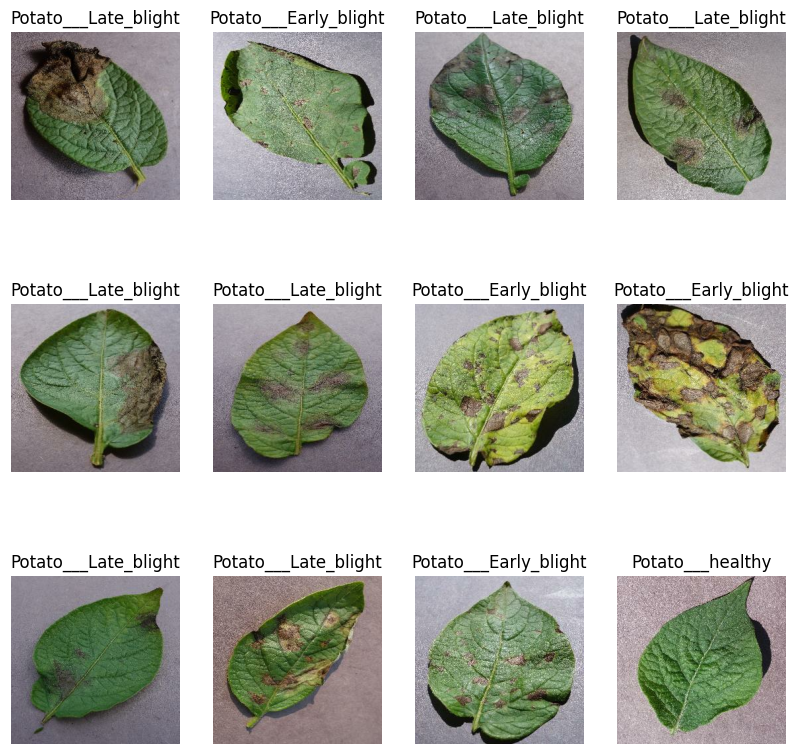

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
train_size= 0.8
len(dataset)*train_size

55.2

In [ ]:
train_size= 0.8
len(dataset)*train_size

55.2

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

15

In [ ]:
val_size=0.1
len(dataset)*val_size

6.9

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

9

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

55

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 3)                1539      
 pper)                                                           
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
__________________________________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

In [ ]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
55/55 [==============================] - 32s 247ms/step - loss: 0.2558 - accuracy: 0.9164 - val_loss: 0.0557 - val_accuracy: 0.9896
Epoch 2/10
55/55 [==============================] - 7s 133ms/step - loss: 0.0659 - accuracy: 0.9752 - val_loss: 0.0309 - val_accuracy: 0.9948
Epoch 3/10
55/55 [==============================] - 7s 121ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 4/10
55/55 [==============================] - 7s 123ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 5/10
55/55 [==============================] - 7s 121ms/step - loss: 0.0077 - accuracy: 0.9994 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/10
55/55 [==============================] - 7s 122ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 7/10
55/55 [==============================] - 7s 135ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch

In [ ]:
scores= resnet_model.evaluate(test_ds)

8/8 [==============================] - 6s 107ms/step - loss: 0.0101 - accuracy: 0.9957


In [ ]:
scores

[0.010105395689606667, 0.9956521987915039]

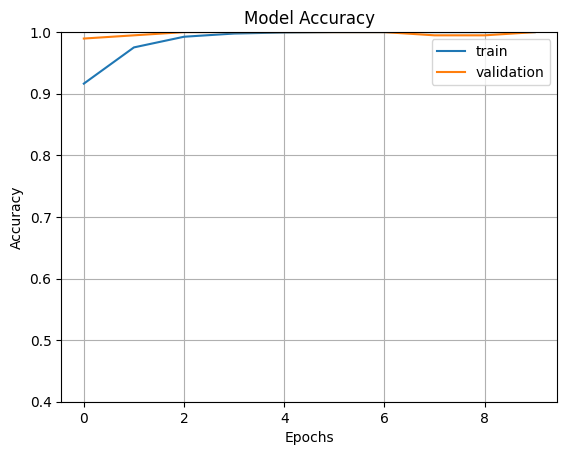

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

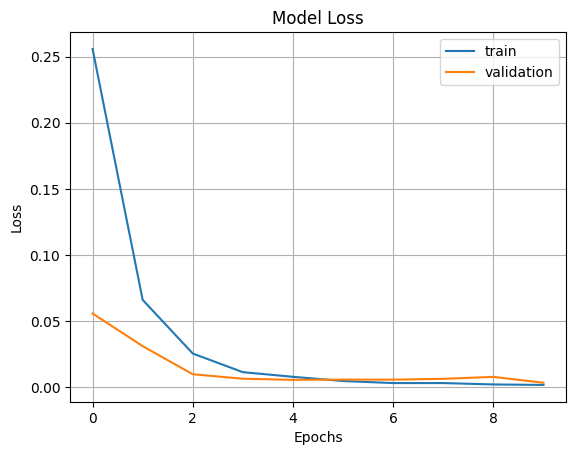

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


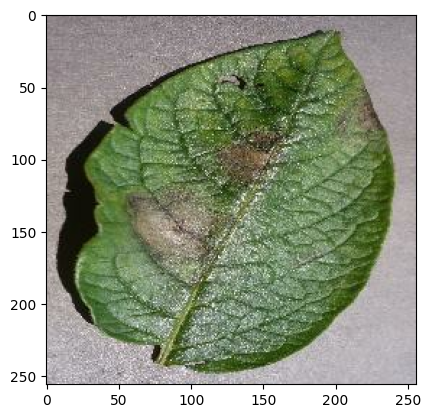

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = resnet_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = resnet_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


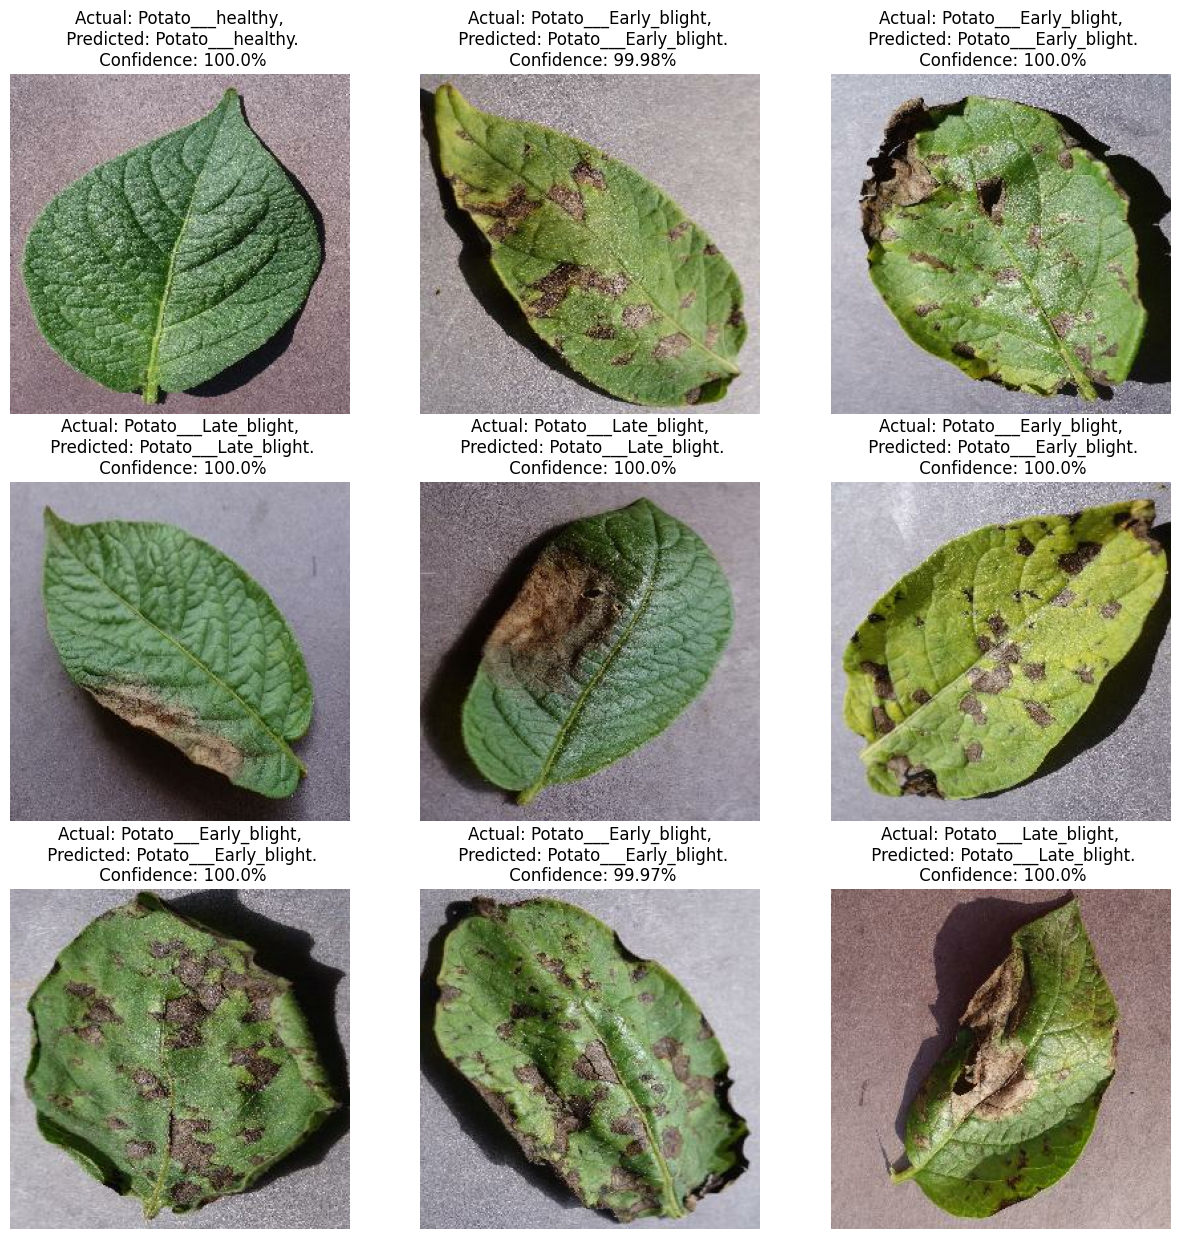

In [ ]:
plt.figure(figsize=(15, 15))
image_count = 0
for images, labels in val_ds.take(1):
    for i in range(9):
        if image_count >= len(images):
            break

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[image_count].numpy().astype("uint8"))

        predicted_class, confidence = predict(resnet_model, images[image_count].numpy())
        actual_class = class_names[labels[image_count]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

        image_count += 1


In [ ]:
import os

model_dir = "/content/drive/MyDrive/GDToT/models1"
os.makedirs(model_dir, exist_ok=True)

model_version = max([int(i) for i in os.listdir(model_dir) + [0]]) + 1
resnet_model.save(f"{model_dir}/{model_version}")